In [ ]:
#cell to make splits from raw pkl files for a specific patient
#saves to labels_jonathan
import os
import pickle
import numpy as np
from temporaldata import Interval

# === Configuration ===
TRAIN_FRAC = 0.8
VAL_FRAC   = 0.1
TEST_FRAC  = 0.1
PATIENT    = '1'

# Paths
BASE_DIR   = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation"
INPUT_DIR  = os.path.join(BASE_DIR, "processed_data", "labels")
OUTPUT_DIR = os.path.join(BASE_DIR, "labels_jonathan")  # already exists

def slice_iv(iv, idxs):
    return Interval(
        start=iv.start[idxs],
        end=iv.end[idxs],
        label=iv.label[idxs],
        timekeys=['start', 'end']
    )

# Process each pkl for this patient
for fname in os.listdir(INPUT_DIR):
    if not (fname.startswith(f'P{PATIENT}_') and fname.endswith('.pkl')):
        continue

    session_id = fname[:-4]  # strip ".pkl"
    in_path    = os.path.join(INPUT_DIR, fname)
    out_path   = os.path.join(OUTPUT_DIR, fname)

    print(f"Loading intervals from {fname}...")

    # 1) load the original Interval object
    with open(in_path, 'rb') as f:
        iv_orig = pickle.load(f)

    # --- Filter out invalid intervals ---
    mask_valid = (iv_orig.start >= 0) & (iv_orig.end >= 60)
    invalid_count = len(iv_orig.start) - int(mask_valid.sum())
    if invalid_count > 0:
        print(f"  Removed {invalid_count} intervals (start<0 or end<60) from {fname}")
    iv_orig = Interval(
        start=iv_orig.start[mask_valid],
        end=iv_orig.end[mask_valid],
        label=iv_orig.label[mask_valid],
        timekeys=['start', 'end']
    )

    # 2) Determine split sizes
    n = len(iv_orig.start)
    val_count   = int(np.floor(n * VAL_FRAC))
    test_count  = int(np.floor(n * TEST_FRAC))
    train_count = n - val_count - test_count

    # 3) Shuffle indices
    indices   = np.random.permutation(n)
    train_idx = indices[:train_count]
    val_idx   = indices[train_count:train_count + val_count]
    test_idx  = indices[train_count + val_count:train_count + val_count + test_count]

    # 4) Build split Intervals
    iv_train = slice_iv(iv_orig, train_idx)
    iv_val   = slice_iv(iv_orig, val_idx)
    iv_test  = slice_iv(iv_orig, test_idx)

    # 5) Prepare splits dict
    splits = {
        'train': {f'halpern_ocd/{session_id}': iv_train},
        'val':   {f'halpern_ocd/{session_id}': iv_val},
        'test':  {f'halpern_ocd/{session_id}': iv_test},
    }

    # 6) Save to output directory
    with open(out_path, 'wb') as f:
        pickle.dump(splits, f)

    print(f"Saved new splits to {out_path}: {train_count} train, {val_count} val, {test_count} test")

print(f"All splits complete for patient {PATIENT}.")





# ## cell to make splits from data that already has splits. Now also filters out splits 
# import os
# import pickle
# import numpy as np
# from temporaldata import Interval

# # === Config===
# TRAIN_FRAC = 0.8
# VAL_FRAC   = 0.1
# TEST_FRAC  = 0.1
# PATIENT    = '5'

# # Paths 
# BASE_DIR  = os.getcwd()
# LABEL_DIR = os.path.join(BASE_DIR, 'labels_jonathan')

# def slice_iv(iv, idxs):
#     return Interval(
#         start=iv.start[idxs],
#         end=iv.end[idxs],
#         label=iv.label[idxs],
#         timekeys=['start', 'end']P5_D5_Tsymptom_provocation_SUPENNS001R01
#     )

# for fname in os.listdir(LABEL_DIR):
#     if not (fname.startswith(f'P{PATIENT}_') and fname.endswith('.pkl')):
#         continue

#     session_id = fname[:-4]  # strip ".pkl"
#     pkl_path   = os.path.join(LABEL_DIR, fname)
#     print(f"Loading splits from {fname}...")

#     # 1) load the existing splits dict
#     with open(pkl_path, 'rb') as f:
#         old_splits = pickle.load(f)

#     # 2) gather all Interval objects into one combined Interval
#     all_intervals = []
#     for split in ('train', 'val', 'test'):
#         for iv in old_splits.get(split, {}).values():
#             all_intervals.append(iv)

#     starts = np.concatenate([iv.start for iv in all_intervals])
#     ends   = np.concatenate([iv.end   for iv in all_intervals])
#     labels = np.concatenate([iv.label for iv in all_intervals])

#     iv_orig = Interval(start=starts, end=ends, label=labels, timekeys=['start', 'end'])



#     n = len(iv_orig.start)

#     # 3) compute new split sizes
#     val_count   = int(np.floor(n * VAL_FRAC))
#     test_count  = int(np.floor(n * TEST_FRAC))
#     train_count = n - val_count - test_count

#     # 4) shuffle and partition
#     idxs      = np.random.permutation(n)
#     train_idx = idxs[:train_count]
#     val_idx   = idxs[train_count:train_count + val_count]
#     test_idx  = idxs[train_count + val_count:train_count + val_count + test_count]

#     iv_train = slice_iv(iv_orig, train_idx)
#     iv_val   = slice_iv(iv_orig, val_idx)
#     iv_test  = slice_iv(iv_orig, test_idx)

#     # 5) assemble the new splits dict (new one doesnt have the halpern_ocd prefix)
#     splits = {
#         'train': {f'halpern_ocd/{session_id}': iv_train},
#         'val':   {f'halpern_ocd/{session_id}': iv_val},
#         'test':  {f'halpern_ocd/{session_id}': iv_test},
#     }

#     # 6) overwrite the original .pkl
#     with open(pkl_path, 'wb') as f:
#         pickle.dump(splits, f)

#     print(f"Saved new splits for {session_id}:",
#           f"{train_count} train,", f"{val_count} val,", f"{test_count} test")

# print(f"All splits complete for patient {PATIENT}.")





Loading intervals from P5_D4_Tsymptom_provocation_SUPENNS001R02.part2.pkl...
Saved new splits to /vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/labels_jonathan/P5_D4_Tsymptom_provocation_SUPENNS001R02.part2.pkl: 16 train, 1 val, 1 test
Loading intervals from P5_D4_Tsymptom_provocation_SUPENNS001R02.part3.pkl...
Saved new splits to /vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/labels_jonathan/P5_D4_Tsymptom_provocation_SUPENNS001R02.part3.pkl: 8 train, 0 val, 0 test
Loading intervals from P5_D4_Tsymptom_provocation_SUPENNS001R02.pkl...
Saved new splits to /vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/labels_jonathan/P5_D4_Tsymptom_provocation_SUPENNS001R02.pkl: 17 train, 2 val, 2 test
Loading intervals from P5_D5_Tsymptom_provocation_SUPENNS001R01.part2.pkl...
Saved new splits to /vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/labels_jonathan/P5_D5_Tsymptom_provocation_SUPENNS001R01.part2.pkl: 16 train, 2 val, 2 test
Loading intervals from P5_D5_Tsymptom_provocation_SUPENNS

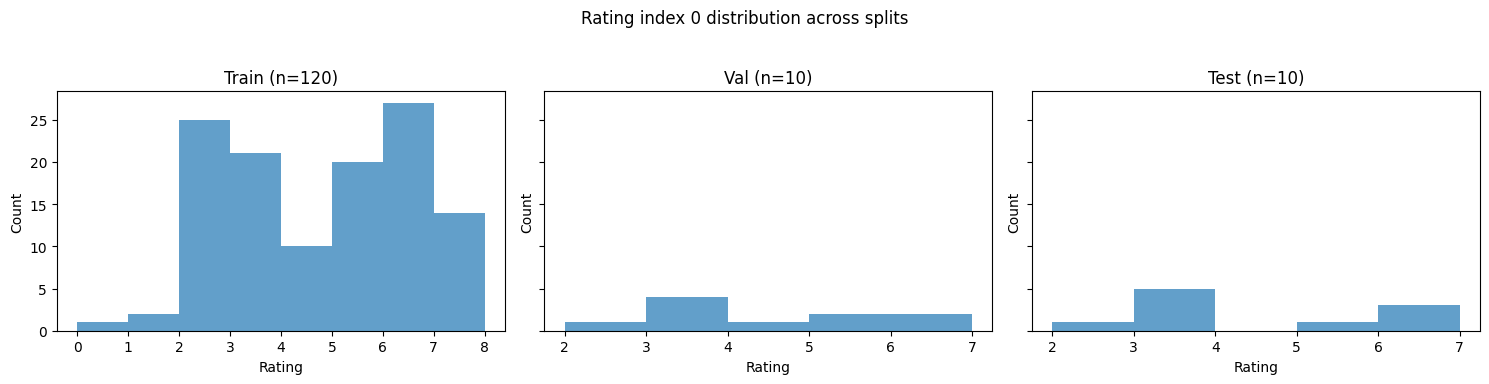

In [35]:
#VISUALIZATION



import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# === Configuration ===
# Select rating index: 0=Obsessions, 1=Compulsions, 2=Anxiety,
# 3=Energy, 4=Depression, 5=Distress
# Updated visualization script — automatically gathers all P5 .pkl files

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

# === Configuration ===
#  Select rating index: 
#    0=Obsessions, 1=Compulsions, 2=Anxiety,
#    3=Energy, 4=Depression, 5=Distress
rating_idx = 0  # e.g. Distress

# Base directory containing split .pkl files
base_dir = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/sequential_splits"

# Automatically collect all Patient 5 files
files = sorted(f for f in os.listdir(base_dir)
               if f.startswith("P5_") and f.endswith(".pkl"))

# Initialize containers for each split
all_ratings = {'train': [], 'val': [], 'test': []}

# Iterate through each file and extract the specified rating
for fname in files:
    pkl_path = os.path.join(base_dir, fname)
    with open(pkl_path, "rb") as f:
        splits = pickle.load(f)
    for split in ('train', 'val', 'test'):
        for iv in splits.get(split, {}).values():
            vals = iv.label[:, rating_idx].astype(float)
            all_ratings[split].append(vals)

# Flatten lists into arrays
for split in all_ratings:
    all_ratings[split] = (np.concatenate(all_ratings[split])
                         if all_ratings[split] else np.array([]))

# Plot histograms side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, split in zip(axes, ('train', 'val', 'test')):
    data = all_ratings[split]
    ax.hist(data, bins='auto', alpha=0.7)
    ax.set_title(f"{split.capitalize()} (n={len(data)})")
    ax.set_xlabel("Rating")
    ax.set_ylabel("Count")

plt.suptitle(f"Rating index {rating_idx} distribution across splits")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()






# import os
# import pickle
# import numpy as np
# import matplotlib.pyplot as plt
# import math

# # === Configuration ===
# LABEL_DIR = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/holdout_splits"

# # Gather Patient 5 files
# files = sorted([f for f in os.listdir(LABEL_DIR) if f.startswith("P5") and f.endswith(".pkl")])
# n_files = len(files)
# if n_files == 0:
#     raise RuntimeError("No Patient 5 .pkl files found in LABEL_DIR")

# # Determine grid size (e.g. 3 columns)
# cols = 3
# rows = math.ceil(n_files / cols)

# fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
# axes = axes.flatten()

# for ax, fname in zip(axes, files):
#     file_path = os.path.join(LABEL_DIR, fname)
#     with open(file_path, "rb") as f:
#         splits = pickle.load(f)

#     # Collect Obsessions ratings only from 'val' split
#     obs_ratings = []
#     for iv in splits.get("val", {}).values():
#         obs_ratings.append(iv.label[:, 0])
#     obs_array = np.concatenate(obs_ratings) if obs_ratings else np.array([])

#     ax.hist(obs_array, bins='auto')
#     ax.set_title(f"{fname}\n(val split)", fontsize=8)
#     ax.set_xlabel("Obsessions")
#     ax.set_ylabel("Count")

# # Turn off any unused subplots
# for ax in axes[n_files:]:
#     ax.axis('off')

# plt.tight_layout()
# plt.show()


In [30]:

"""
Cell to check the splits structure, validate the splits, and print counts.
"""
# 1) Point to your labels directory and a session to check
label_dir = os.path.join(os.getcwd(), 'processed_data', 'labels')
session_id = 'P5_D5_Tsymptom_provocation_SUPENNS001R01'
pkl_path = os.path.join(label_dir, f"{session_id}.pkl")

# 2) Load the splits dict
with open(pkl_path, 'rb') as f:
    splits = pickle.load(f)

# 3) Print out the structure and interval counts
print("Splits found:", list(splits.keys()))
for split, split_dict in splits.items():
    for sid, iv in split_dict.items():
        count = len(iv.start) if hasattr(iv, 'start') else 'N/A'
        print(f"{split:<5} | session = {sid:<40} | intervals = {count}")


import os, pickle

# Pick one of your pkl files
pkl_file = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/labels_jonathan/P5_D3_Tsymptom_provocation_SUPENNS001R01.pkl"

with open(pkl_file, "rb") as f:
    data = pickle.load(f)

print("Type:", type(data))
if isinstance(data, dict):
    print("Keys:", list(data.keys()))
else:
    # e.g. an Interval object
    print("repr:", data)



import os
import pickle
import numpy as np

# === Configuration ===
# Directory containing Patient 5 split-pkl files
LABEL_DIR = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/labels_jonathan"

# Initialize counters
counts = {
    "train": {"high": 0, "low": 0},
    "val":   {"high": 0, "low": 0},
    "test":  {"high": 0, "low": 0},
}

# Process each Patient 5 file
for fname in os.listdir(LABEL_DIR):
    if not (fname.startswith("P3_") and fname.endswith(".pkl")):
        continue

    file_path = os.path.join(LABEL_DIR, fname)
    with open(file_path, "rb") as f:
        splits = pickle.load(f)

    # Count obsession ratings >4 and <=4 for each split
    for split in ("train", "val", "test"):
        for iv in splits.get(split, {}).values():
            obs = iv.label[:, 0]  # column 0 is Obsessions
            counts[split]["high"] += int(np.sum(obs > 4))
            counts[split]["low"]  += int(np.sum(obs <= 4))

# Print summary
print("Obsession rating counts for Patient 3:")
for split in ("train", "val", "test"):
    high = counts[split]["high"]
    low  = counts[split]["low"]
    print(f"  {split.capitalize()}: >4 = {high}, <=4 = {low}")


Splits found: ['start', 'end', 'label']


AttributeError: 'Interval' object has no attribute 'items'

In [ ]:
import os
import pickle

# 1) split‑cache directory:
BASE_DIR = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/processed_data_upd/split_cache/ocd_symptom_provocation"

# 2) Iterate over each session folder
for session_folder in sorted(os.listdir(BASE_DIR)):
    folder_path = os.path.join(BASE_DIR, session_folder)
    if not os.path.isdir(folder_path):
        continue

    pkl_path = os.path.join(folder_path, "multilabel.pkl")
    if not os.path.isfile(pkl_path):
        print(f"  Missing multilabel.pkl in {session_folder}")
        continue

    with open(pkl_path, "rb") as f:
        splits = pickle.load(f)

    print(f"\nSession Folder: {session_folder}")
    # 3) For each split, compute and report zero‑length intervals
    for split_name, split_dict in splits.items():
        print(f"  Split: {split_name}")
        for key, iv in split_dict.items():
            durations = iv.end - iv.start
            zero_count = int((durations == 0).sum())
            print(f"    Key: {key}")
            print(f"      Total intervals:       {len(durations)}")
            print(f"      Zero-length intervals: {zero_count}")


⚠️  Missing multilabel.pkl in P5_D3_Tsymptom_provocation_SUPENNS001R01
⚠️  Missing multilabel.pkl in P5_D3_Tsymptom_provocation_SUPENNS001R01.part2
⚠️  Missing multilabel.pkl in P5_D3_Tsymptom_provocation_SUPENNS001R01.part3
⚠️  Missing multilabel.pkl in P5_D3_Tsymptom_provocation_SUPENNS001R01.part4

Session Folder: P5_D4_Tsymptom_provocation_SUPENNS001R02
  Split: train
    Key: P5_D4_Tsymptom_provocation_SUPENNS001R02
      Total intervals:       17
      Zero-length intervals: 0
  Split: val
    Key: P5_D4_Tsymptom_provocation_SUPENNS001R02
      Total intervals:       2
      Zero-length intervals: 0
  Split: test
    Key: P5_D4_Tsymptom_provocation_SUPENNS001R02
      Total intervals:       2
      Zero-length intervals: 0

Session Folder: P5_D4_Tsymptom_provocation_SUPENNS001R02.part2
  Split: train
    Key: P5_D4_Tsymptom_provocation_SUPENNS001R02.part2
      Total intervals:       16
      Zero-length intervals: 0
  Split: val
    Key: P5_D4_Tsymptom_provocation_SUPENNS001R02.

In [17]:
# Cell to make data loaders

# START HERE FOR MODEL TRAINING

import os
import pickle
import yaml
import torch
from torch.utils.data import DataLoader
import numpy as np

from torch_brain.data import Dataset, chain
from torch_brain.data.collate import collate
from torch_brain.data.sampler import (
    RandomFixedWindowSampler,
    SequentialFixedWindowSampler,
)



cfg = yaml.safe_load(open("config.yaml"))
# cfg is a list with one element; that element has a key "selection" mapping to a dict,
# and that dict has your "sessions" list.
session_list = cfg[0]["selection"][0]["sessions"]

# 2) Define file roots (update these to where your files actually live)
base_root  = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation"
h5_root    = os.path.join(
    base_root,
    "processed_data_upd",
    "processed_data"
)
label_root = os.path.join(
    base_root,
    "labels_jonathan"
)

# 3) Create the Dataset object
total_dataset = Dataset(
    root=h5_root,
    split=None,
    config="config.yaml",  
    # drop the subject prefix — only use the session.id
    session_id_prefix_fn=lambda d: "ocd_symptom_provocation/"
    )   


def tokensize(data):
    return data.ieeg.data

total_dataset.transform = tokensize

# 4) Read each .pkl to collect train/val/test intervals
sampling_intervals = {"train": {}, "val": {}, "test": {}}

for session_id in session_list:
    pkl_path = os.path.join(label_root, session_id + ".pkl")
    with open(pkl_path, "rb") as f:
        splits = pickle.load(f)

    for split in ("train", "val", "test"):
        iv = splits.get(split, {}).get(f'halpern_ocd/{session_id}')
        if iv is not None:
            sampling_intervals[split][f'ocd_symptom_provocation/{session_id}'] = iv


# 5) Hyperparameters (hard‑coded)
batch_size     = 2
num_workers    = 1
prefetch_factor= 1
window_length  = 1.0  # seconds

# 6) Create samplers for each split
train_sampler = RandomFixedWindowSampler(
    sampling_intervals=sampling_intervals["train"],
    window_length=1,
    generator=torch.Generator().manual_seed(0),
)
val_sampler = SequentialFixedWindowSampler(
    sampling_intervals=sampling_intervals["val"],
    window_length=1,
)
test_sampler = SequentialFixedWindowSampler(
    sampling_intervals=sampling_intervals["test"],
    window_length=1,
)

# 7) Wrap samplers in DataLoaders
train_loader = DataLoader(
    total_dataset, batch_size=batch_size, sampler=train_sampler,
    collate_fn=collate, num_workers=num_workers,
    drop_last=True, persistent_workers=True,
    prefetch_factor=prefetch_factor,
)
val_loader = DataLoader(
    total_dataset, batch_size=batch_size, sampler=val_sampler,
    collate_fn=collate, num_workers=num_workers,
    drop_last=False, persistent_workers=True,
    prefetch_factor=prefetch_factor,
)
test_loader = DataLoader(
    total_dataset, batch_size=batch_size, sampler=test_sampler,
    collate_fn=collate, num_workers=num_workers,
    drop_last=False, persistent_workers=True,
    prefetch_factor=prefetch_factor,
)

# — now train_loader / val_loader / test_loader pull exactly from:
#    - HD5 files under processed_data_upd
#    - interval splits under processed_data/labels




# for session in total_dataset.get_session_ids():
#     with open(filename, 'rb') as f:
#         intervals = pickle.load(f)
#         train_sampling_intervals[session] = intervals['train'][session]

# # Define train/val/test data loaders
# train_sampler = RandomFixedWindowSampler(
#     sampling_intervals=train_sampling_intervals,
#     window_length=1.0,  # seconds
#     generator=torch.Generator().manual_seed(0),
# )
# train_loader = DataLoader(
#     dataset=total_dataset,
#     batch_size=10,
#     sampler=train_sampler,
#     collate_fn=collate,
#     num_workers=1,
#     drop_last=True,
#     persistent_workers=True,
#     prefetch_factor=1,
# )


In [18]:
while True:     
    sample = next(iter(train_sampler))
    temp = total_dataset.__getitem__(sample)
    if np.shape(temp)[0] == 0:
        print(np.shape(temp))



KeyboardInterrupt: 

In [19]:
mysample = total_dataset.get(recording_id='ocd_symptom_provocation/P5_D5_Tsymptom_provocation_SUPENNS001R01', start=2451.198575882117, end=2452.198575882117)

mysample.ieeg.data[:]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [21]:
# Diagnostic — list every recording your Dataset knows about
print("Dataset sessions:")
for sid in total_dataset.get_session_ids():
    print("  ", sid)


Dataset sessions:
   ocd_symptom_provocation/P5_D3_Tsymptom_provocation_SUPENNS001R01
   ocd_symptom_provocation/P5_D3_Tsymptom_provocation_SUPENNS001R01.part2
   ocd_symptom_provocation/P5_D3_Tsymptom_provocation_SUPENNS001R01.part3
   ocd_symptom_provocation/P5_D3_Tsymptom_provocation_SUPENNS001R01.part4
   ocd_symptom_provocation/P5_D4_Tsymptom_provocation_SUPENNS001R02
   ocd_symptom_provocation/P5_D4_Tsymptom_provocation_SUPENNS001R02.part2
   ocd_symptom_provocation/P5_D4_Tsymptom_provocation_SUPENNS001R02.part3
   ocd_symptom_provocation/P5_D5_Tsymptom_provocation_SUPENNS001R01
   ocd_symptom_provocation/P5_D5_Tsymptom_provocation_SUPENNS001R01.part2
   ocd_symptom_provocation/P5_D5_Tsymptom_provocation_SUPENNS001R01.part3


In [22]:
with open("labels_jonathan/P5_D4_Tsymptom_provocation_SUPENNS001R02.pkl", "rb") as f:
    d = pickle.load(f)
print("train keys:", d["train"].keys())


train keys: dict_keys(['halpern_ocd/P5_D4_Tsymptom_provocation_SUPENNS001R02'])


In [23]:
# Cell — inspect train interval durations

# — Diagnostic cell — verify sampling_intervals exists and has data
try:
    print("sampling_intervals keys:", sampling_intervals.keys())
    print("  train sessions:", list(    ["train"].keys()))
    print("  # train sessions:", len(sampling_intervals["train"]))
except NameError:
    print("sampling_intervals is not defined in this scope.")


for session_id, intervals in sampling_intervals["train"].items():
    # compute duration of each interval
    durations = [end - start for start, end in intervals]
    if not durations:
        print(f"{session_id}: no intervals")
        continue
    print(f"Session {session_id}:")
    print(f"  # intervals = {len(durations)}")
    print(f"  Example durations (first 5) = {durations[:5]}")
    print(f"  Min = {min(durations)}, Max = {max(durations)}, Mean = {sum(durations)/len(durations):.3f}")
    print()
    # break after first session if you only want one example
    break

print(sampling_intervals["train"])


sampling_intervals keys: dict_keys(['train', 'val', 'test'])


AttributeError: 'list' object has no attribute 'keys'

In [24]:
# Cell — run one iteration of train_loader
train_iter = iter(train_loader)
try:
    batch = next(train_iter)
    print(batch)
except StopIteration:
    raise RuntimeError("train_loader is empty—check your sampler and intervals.")

# If your Dataset returns (inputs, labels):
if isinstance(batch, (list, tuple)) and len(batch) == 2:
    inputs, labels = batch
    print("Inputs type:", type(inputs), "shape:", getattr(inputs, "shape", None))
    print("Labels type:", type(labels), "shape:", getattr(labels, "shape", None))
# If your Dataset returns a dict:
elif isinstance(batch, dict):
    for k, v in batch.items():
        print(f"{k}: type={type(v)}, shape={getattr(v, 'shape', None)}")
else:
    print("Batch content:", batch)


tensor([[[-16.7614, -15.8564, -18.2223,  ..., -15.1820, -11.3796,  -9.7417],
         [-19.4773, -19.8650, -19.0437,  ..., -17.3371, -12.0226, -10.3874],
         [-18.2371, -20.7020, -18.6056,  ..., -17.8583, -10.8468,  -8.0474],
         ...,
         [  7.9974,   6.3068,   6.0047,  ..., -51.8303, -65.0006, -56.7056],
         [  4.2996,   1.6088,   2.3571,  ..., -53.5114, -67.4040, -61.1174],
         [ -4.3021,  -5.5142,  -5.8487,  ..., -62.3035, -77.7725, -70.7972]],

        [[ -7.3690,  -4.6519,  -7.0875,  ...,  -8.7475, -17.6186, -19.9336],
         [-15.7518, -13.1334, -13.3663,  ..., -16.7485, -27.7483, -30.2338],
         [-16.0651, -15.5950, -14.7030,  ..., -21.0899, -37.0033, -39.7273],
         ...,
         [ -8.0853,  -8.7111,  -5.6530,  ..., -17.2054, -36.2070, -46.2382],
         [ -2.5171,  -2.0650,   2.5676,  ...,  -8.0953, -29.8972, -40.2408],
         [ -1.3657,  -1.6218,   1.3435,  ...,  -8.7440, -33.8240, -40.3319]]],
       dtype=torch.float64)
Batch content: t

In [25]:
total_dataset._data_objects

{'ocd_symptom_provocation/P5_D3_Tsymptom_provocation_SUPENNS001R01': Data(
 brainset=Data(
 brainsets_version='0.1.0',
 derived_version='',
 description='',
 id='halpern_ocd',
 origin_version='',
 source='',
 temporaldata_version='0.1.1',
 _absolute_start=0.0,
 ),
 ieeg=LazyRegularTimeSeries(
   data=<HDF5 dataset "data": shape (1800050, 240), type "<f8">
 ),
 session=Data(
 id='P5_D3_Tsymptom_provocation_SUPENNS001R01',
 recording_date='2025-02-07 00:00:00',
 _absolute_start=0.0,
 ),
 subject=Data(
 age=0.0,
 genotype='unknown',
 id='patient5',
 sex='UNKNOWN',
 species='HOMO_SAPIENS',
 _absolute_start=0.0,
 ),
 units=LazyArrayDict(
   brain_area=<HDF5 dataset "brain_area": shape (240,), type "|O">,
   id=<HDF5 dataset "id": shape (240,), type "|S4">,
   x=<HDF5 dataset "x": shape (240,), type "<f8">,
   y=<HDF5 dataset "y": shape (240,), type "<f8">,
   z=<HDF5 dataset "z": shape (240,), type "<f8">
 ),
 _absolute_start=0.0,
 ),
 'ocd_symptom_provocation/P5_D3_Tsymptom_provocation_SUP

In [26]:
import h5py

# Open the file in read mode
with h5py.File('/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation/processed_data_upd/processed_data/ocd_symptom_provocation/P5_D5_Tsymptom_provocation_SUPENNS001R01.h5', 'r') as f:
    # List all groups/datasets in the file
    print("Keys:", list(f.keys()))
    # Access a dataset
    data = dir(f['subject'].id)
    print(data)

Keys: ['brainset', 'domain', 'ieeg', 'session', 'subject', 'units']
['__bool__', '__class__', '__contains__', '__copy__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_cython__', '__reduce_ex__', '__repr__', '__reversed__', '__setattr__', '__setstate__', '__setstate_cython__', '__sizeof__', '__str__', '__subclasshook__', '_close', 'close', 'fileno', 'get_comment', 'get_create_plist', 'get_linkval', 'get_num_objs', 'get_objname_by_idx', 'get_objtype_by_idx', 'id', 'link', 'links', 'locked', 'move', 'set_comment', 'unlink', 'valid']
